# Week 3 - Data Engineering

Goal: Identify churned customers based on “past 3 months with no transactions”
with behavioral features “past 3 months prior to churn”

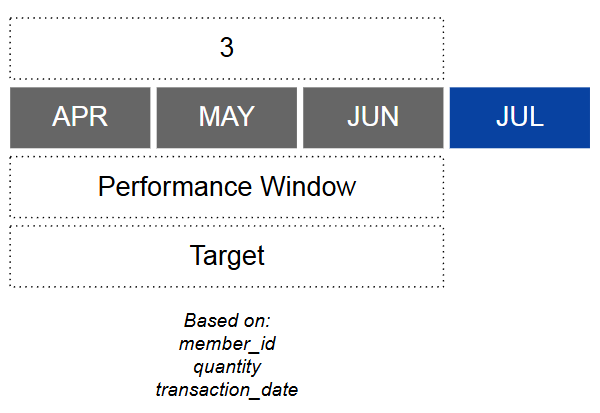

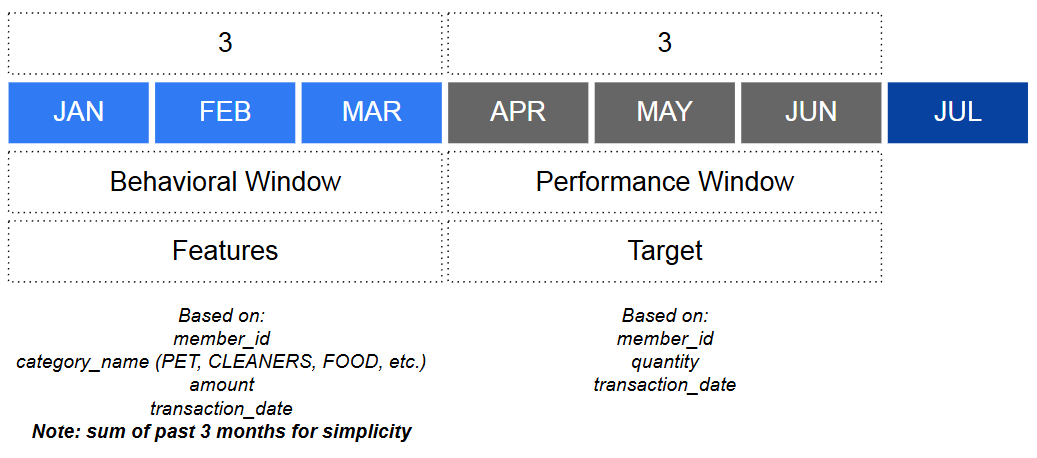

# Activity

**Goal:** Replicate live demo notebook into individual lab notebook

**Data To Be Used:** week2_data_for_student_lab.csv.gz

In [17]:
# Installing the packages
!pip install pyspark
!pip install findspark

In [18]:
# Setting up pyspark
import findspark
findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession.builder \
        .master('local[*]') \
        .appName('Basics') \
        .getOrCreate()

print(spark.version)

3.5.4


In [19]:
# Importing packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [20]:
df_2018 = spark.read.csv(f"/content/drive/MyDrive/ TERM 7/MACHINE/churn_prediction/data/week2_data_for_student_lab.csv.gz", inferSchema=True, header=True)
df_2018.show(5)
df_2018.createOrReplaceTempView("df_2018_view")

+----------------+-----------+--------------------+------+-------+--------+------+-----+---------+-----------+------+-------------+
|transaction_date|member_type|           member_id|gender|product|quantity|amount|  age|card_type|branch_name|region|category_name|
+----------------+-----------+--------------------+------+-------+--------+------+-----+---------+-----------+------+-------------+
|      2018-04-01|     member|ff96777d-cfda-11e...|FEMALE|   3267|      16|  5100|30-35|  REGULAR|    E_Store|     3|  FROZEN FOOD|
|      2018-04-09|     member|00d89024-cfdb-11e...|FEMALE|   6748|       1|  1100|55-60|  REGULAR|    A_Store|     1|          PET|
|      2018-04-01|     member|00858b3b-cfdb-11e...|FEMALE|    420|       4|  5300|55-60|  REGULAR|    A_Store|     1|          PET|
|      2018-04-13|     member|001035ed-cfdb-11e...|FEMALE|   3178|      16|  5600|45-50|  REGULAR|    A_Store|     1|      GADGETS|
|      2018-04-15|     member|ff5fafeb-cfda-11e...|FEMALE|   2727|      19| 

In [21]:
df_2018.columns

['transaction_date',
 'member_type',
 'member_id',
 'gender',
 'product',
 'quantity',
 'amount',
 'age',
 'card_type',
 'branch_name',
 'region',
 'category_name']

In [23]:
spark.sql('''
SELECT COUNT
  (DISTINCT category_name)
FROM
  df_2018_view
  ''').show()

+-----------------------------+
|count(DISTINCT category_name)|
+-----------------------------+
|                           10|
+-----------------------------+



In [24]:
spark.sql('''
SELECT DISTINCT
  category_name
FROM
  df_2018_view
ORDER BY
  category_name ASC
  ''').show()

+-------------+
|category_name|
+-------------+
|  ACCESSORIES|
|   APPLIANCES|
|     CLEANERS|
|      CLOTHES|
|         FOOD|
|  FROZEN FOOD|
|      GADGETS|
|     HARDWARE|
|          PET|
|        SHOES|
+-------------+



In [25]:
# Checking the first 5 rows of data
spark.sql('''
SELECT
  *
FROM
  df_2018_view
LIMIT
  5
''').show()

+----------------+-----------+--------------------+------+-------+--------+------+-----+---------+-----------+------+-------------+
|transaction_date|member_type|           member_id|gender|product|quantity|amount|  age|card_type|branch_name|region|category_name|
+----------------+-----------+--------------------+------+-------+--------+------+-----+---------+-----------+------+-------------+
|      2018-04-01|     member|ff96777d-cfda-11e...|FEMALE|   3267|      16|  5100|30-35|  REGULAR|    E_Store|     3|  FROZEN FOOD|
|      2018-04-09|     member|00d89024-cfdb-11e...|FEMALE|   6748|       1|  1100|55-60|  REGULAR|    A_Store|     1|          PET|
|      2018-04-01|     member|00858b3b-cfdb-11e...|FEMALE|    420|       4|  5300|55-60|  REGULAR|    A_Store|     1|          PET|
|      2018-04-13|     member|001035ed-cfdb-11e...|FEMALE|   3178|      16|  5600|45-50|  REGULAR|    A_Store|     1|      GADGETS|
|      2018-04-15|     member|ff5fafeb-cfda-11e...|FEMALE|   2727|      19| 

In [26]:
spark.sql('''
WITH customers_in_april AS (
  SELECT DISTINCT member_id
  FROM df_2018_view
  WHERE transaction_date BETWEEN '2018-04-01' AND '2018-04-30'
),
customers_in_april_joined_with_past_3_months_txn AS (
  SELECT
    a.member_id,
    b.quantity,
    b.transaction_date
  FROM
    customers_in_april AS a
  LEFT JOIN
    df_2018_view AS b
  ON
    a.member_id = b.member_id
  WHERE
    b.transaction_date BETWEEN '2018-01-01' AND '2018-03-31'
),
aggregated_total_txns_in_april AS (
  SELECT
    member_id,
    SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-01-31' THEN quantity ELSE 0 END) AS pm3_total_txn,
    SUM(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-02-28' THEN quantity ELSE 0 END) AS pm2_total_txn,
    SUM(CASE WHEN transaction_date BETWEEN '2018-03-01' AND '2018-03-31' THEN quantity ELSE 0 END) AS pm1_total_txn,
    '2018-04-01' AS PARTITION_MONTH
  FROM
    customers_in_april_joined_with_past_3_months_txn
  GROUP BY
    member_id
),
customers_in_may AS (
  SELECT DISTINCT member_id
  FROM df_2018_view
  WHERE transaction_date BETWEEN '2018-05-01' AND '2018-05-31'
),
customers_in_may_joined_with_past_3_months_txn AS (
  SELECT
    a.member_id,
    b.quantity,
    b.transaction_date
  FROM
    customers_in_may AS a
  LEFT JOIN
    df_2018_view AS b
  ON
    a.member_id = b.member_id
  WHERE
    b.transaction_date BETWEEN '2018-02-01' AND '2018-04-30'
),
aggregated_total_txns_in_may AS (
  SELECT
    member_id,
    SUM(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-02-28' THEN quantity ELSE 0 END) AS pm3_total_txn,
    SUM(CASE WHEN transaction_date BETWEEN '2018-03-01' AND '2018-03-31' THEN quantity ELSE 0 END) AS pm2_total_txn,
    SUM(CASE WHEN transaction_date BETWEEN '2018-04-01' AND '2018-04-30' THEN quantity ELSE 0 END) AS pm1_total_txn,
    '2018-05-01' AS PARTITION_MONTH
  FROM
    customers_in_may_joined_with_past_3_months_txn
  GROUP BY
    member_id
),
customers_in_june AS (
  SELECT DISTINCT member_id
  FROM df_2018_view
  WHERE transaction_date BETWEEN '2018-06-01' AND '2018-06-30'
),
customers_in_june_joined_with_past_3_months_txn AS (
  SELECT
    a.member_id,
    b.quantity,
    b.transaction_date
  FROM
    customers_in_june AS a
  LEFT JOIN
    df_2018_view AS b
  ON
    a.member_id = b.member_id
  WHERE
    b.transaction_date BETWEEN '2018-03-01' AND '2018-05-31'
),
aggregated_total_txns_in_june AS (
  SELECT
    member_id,
    SUM(CASE WHEN transaction_date BETWEEN '2018-03-01' AND '2018-03-31' THEN quantity ELSE 0 END) AS pm3_total_txn,
    SUM(CASE WHEN transaction_date BETWEEN '2018-04-01' AND '2018-04-30' THEN quantity ELSE 0 END) AS pm2_total_txn,
    SUM(CASE WHEN transaction_date BETWEEN '2018-05-01' AND '2018-05-31' THEN quantity ELSE 0 END) AS pm1_total_txn,
    '2018-06-01' AS PARTITION_MONTH
  FROM
    customers_in_june_joined_with_past_3_months_txn
  GROUP BY
    member_id
),
union_all_aggregated_txns AS (
  SELECT * FROM aggregated_total_txns_in_april
  UNION ALL
  SELECT * FROM aggregated_total_txns_in_may
  UNION ALL
  SELECT * FROM aggregated_total_txns_in_june
)
SELECT
    PARTITION_MONTH,
    COUNT(member_id) AS total_member_id
FROM
    union_all_aggregated_txns
GROUP BY
    PARTITION_MONTH
ORDER BY
    PARTITION_MONTH
''').show()

+---------------+---------------+
|PARTITION_MONTH|total_member_id|
+---------------+---------------+
|     2018-04-01|          59143|
|     2018-05-01|          84325|
|     2018-06-01|          89658|
+---------------+---------------+



In [28]:
# Show first 5 rows of features for modeling
spark.sql('''
WITH
customer_base AS (
SELECT
  DISTINCT member_id
FROM
  df_2018_view
WHERE
  transaction_date BETWEEN '2018-07-01' AND '2018-07-30'
)
,customer_base_joined_with_past_3_months_txn AS (
SELECT
  a.member_id
  ,b.quantity
  ,b.transaction_date
FROM
  customer_base AS a
LEFT JOIN
  df_2018_view AS b
ON
  a.member_id = b.member_id
AND
  b.transaction_date BETWEEN '2018-04-01' AND '2018-06-30'
)
,customer_base_with_aggregated_total_txns_per_month AS (
SELECT
   member_id
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-04-01' AND '2018-06-30' THEN quantity ELSE 0 END) AS sum_quantity
  ,'2018-06-01' AS partition_date
FROM
  customer_base_joined_with_past_3_months_txn
GROUP BY
  member_id
)
,customers_with_target_definition AS (
SELECT
  *
  ,CASE
    WHEN sum_quantity = 0 THEN 1
    ELSE 0
    END AS target
FROM
  customer_base_with_aggregated_total_txns_per_month
)
,count_customers_with_target_definition AS (
SELECT
  target
  ,COUNT(member_id) AS cnt_member_id
  ,COUNT(DISTINCT member_id) AS cntd_member_id
FROM
  customers_with_target_definition
GROUP BY
  target
)
,customers_joined_with_features AS (
SELECT
  a.member_id
  ,b.quantity
  ,b.amount
  ,b.category_name
  ,b.transaction_date
FROM
  customers_with_target_definition AS a
LEFT JOIN
  df_2018_view AS b
ON
  a.member_id = b.member_id
AND
  b.transaction_date BETWEEN '2018-01-01' AND '2018-03-31'
)
,aggregated_categories AS (
SELECT
   member_id
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('ACCESSORIES') THEN amount ELSE 0 END) AS sum_amount_accessories
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('APPLIANCES') THEN amount ELSE 0 END) AS sum_amount_appliances
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('CLEANERS') THEN amount ELSE 0 END) AS sum_amount_cleaners

  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('CLOTHES') THEN amount ELSE 0 END) AS sum_amount_clothes
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('FOOD') THEN amount ELSE 0 END) AS sum_amount_food
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('FROZEN FOOD') THEN amount ELSE 0 END) AS sum_amount_frozen_food

  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('GADGETS') THEN amount ELSE 0 END) AS sum_amount_gadgets
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('HARDWARE') THEN amount ELSE 0 END) AS sum_amount_hardware
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('PET') THEN amount ELSE 0 END) AS sum_amount_pet

  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('SHOES') THEN amount ELSE 0 END) AS sum_amount_shoes

FROM
  customers_joined_with_features
GROUP BY
  member_id
)
,customers_with_target_joined_with_features AS (
SELECT
  a.member_id
  ,a.target
  ,a.partition_date
  ,b.sum_amount_accessories
  ,b.sum_amount_appliances
  ,b.sum_amount_cleaners
  ,b.sum_amount_clothes
  ,b.sum_amount_food
  ,b.sum_amount_frozen_food
  ,b.sum_amount_gadgets
  ,b.sum_amount_hardware
  ,b.sum_amount_pet
  ,b.sum_amount_shoes
FROM
  customers_with_target_definition AS a
LEFT JOIN
  aggregated_categories AS b
ON
  a.member_id = b.member_id
)

SELECT
  *
FROM
  customers_with_target_joined_with_features LIMIT 5
  --count_customers_with_target_definition
''').show()

+--------------------+------+--------------+----------------------+---------------------+-------------------+------------------+---------------+----------------------+------------------+-------------------+--------------+----------------+
|           member_id|target|partition_date|sum_amount_accessories|sum_amount_appliances|sum_amount_cleaners|sum_amount_clothes|sum_amount_food|sum_amount_frozen_food|sum_amount_gadgets|sum_amount_hardware|sum_amount_pet|sum_amount_shoes|
+--------------------+------+--------------+----------------------+---------------------+-------------------+------------------+---------------+----------------------+------------------+-------------------+--------------+----------------+
|001787f6-cfdb-11e...|     0|    2018-06-01|                     0|                    0|                  0|                 0|              0|                     0|                 0|                  0|             0|               0|
|010ee11a-cfdb-11e...|     0|    2018-06-01|

In [27]:
spark.sql('''
WITH
customers_in_july AS (
SELECT
  DISTINCT member_id
FROM
  df_2018_view
WHERE
  transaction_date BETWEEN '2018-07-01' AND '2018-07-31'
)
,customers_in_july_joined_with_past_transactions AS (
SELECT
  a.member_id
  ,b.quantity
  ,b.amount
  ,b.transaction_date
FROM
  customers_in_july AS a
LEFT JOIN
  df_2018_view AS b
ON
  a.member_id = b.member_id
AND
  b.transaction_date BETWEEN '2018-01-01' AND '2018-06-30'
)
,aggregated_total_txns_per_month AS (
SELECT
   member_id
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-04-01' AND '2018-04-30' THEN quantity ELSE 0 END) AS pm3_total_txn
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-05-01' AND '2018-05-31' THEN quantity ELSE 0 END) AS pm2_total_txn
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-06-01' AND '2018-06-30' THEN quantity ELSE 0 END) AS pm1_total_txn
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-07-01' AND '2018-07-31' THEN quantity ELSE 0 END) AS pm0_total_txn
  ,'2018-07-01' AS PARTITION_MONTH
FROM
  customers_in_july_joined_with_past_transactions
GROUP BY
  member_id
)
,customers_with_target_definition AS (
SELECT
  *
  ,CASE
    WHEN pm1_total_txn = 0 AND pm2_total_txn = 0 AND pm3_total_txn = 0 THEN 1
    ELSE 0
    END AS target
FROM
  aggregated_total_txns_per_month
)
,customers_joined_with_features AS (
SELECT
  a.member_id
  ,b.quantity
  ,b.amount
  ,b.category_name
  ,b.transaction_date
FROM
  customers_in_july AS a
LEFT JOIN
  df_2018_view AS b
ON
  a.member_id = b.member_id
AND
  b.transaction_date BETWEEN '2018-01-01' AND '2018-03-31'
)
,aggregated_categories AS (
SELECT
   member_id

  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('ACCESSORIES') THEN amount ELSE 0 END) AS pm_accessories
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('APPLIANCES') THEN amount ELSE 0 END) AS pm_appliances
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('CLEANERS') THEN amount ELSE 0 END) AS pm_cleaners

  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('CLOTHES') THEN amount ELSE 0 END) AS pm_clothes
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('FOOD') THEN amount ELSE 0 END) AS pm_food
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('FROZEN FOOD') THEN amount ELSE 0 END) AS pm_frozen_food

  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('GADGETS') THEN amount ELSE 0 END) AS pm_gadgets
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('HARDWARE') THEN amount ELSE 0 END) AS pm_hardware
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('PET') THEN amount ELSE 0 END) AS pm_pet

  ,SUM(CASE WHEN transaction_date BETWEEN '2018-01-01' AND '2018-03-31' AND category_name IN ('SHOES') THEN amount ELSE 0 END) AS pm_shoes

FROM
  customers_joined_with_features
GROUP BY
  member_id
)
,customers_with_target_joined_with_features AS (
SELECT
  a.member_id
  ,a.target
  ,b.pm_accessories
  ,b.pm_appliances
  ,b.pm_cleaners
  ,b.pm_clothes
  ,b.pm_food
  ,b.pm_frozen_food
  ,b.pm_gadgets
  ,b.pm_hardware
  ,b.pm_pet
  ,b.pm_shoes
FROM
  customers_with_target_definition AS a
LEFT JOIN
  aggregated_categories AS b
ON
  a.member_id = b.member_id
)

,count_customers_with_target_definition AS (
SELECT
  target
  ,COUNT(member_id) AS cnt_member_id
  ,COUNT(DISTINCT member_id) AS cntd_member_id
FROM
  customers_with_target_definition
GROUP BY
  target
)

SELECT
  *
FROM
  count_customers_with_target_definition
''').show()

+------+-------------+--------------+
|target|cnt_member_id|cntd_member_id|
+------+-------------+--------------+
|     1|        15873|         15873|
|     0|        34794|         34794|
+------+-------------+--------------+



In [29]:
(34794/(15832+34794))

0.6872753130802355

In [31]:
# Churn rate in %
(34794/(15832+34794))*100

68.72753130802354